In [32]:
import pandas as pd
import numpy as np
import cv2
import os
import pickle
from matplotlib import pyplot as plt
# import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from collections import Counter
%matplotlib inline

plt.rc("figure", dpi = 150, figsize = (12,8))

hog_path = "./HOG"
hog_labels = os.listdir(hog_path)

selected_hog_labels = ["00011", "00013", "00009"] 

def draw_img(hog_label, hog_name):
    img_name = hog_name.split('.')[0] + '.jpg'
    img = cv2.imread(os.path.join("./images", hog_label, img_name))
    plt.imshow(img, cmap = "gray")
    plt.show()


In [69]:
svc = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True,
    probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=True, max_iter=-1,
    decision_function_shape='ovr', random_state=None)

pca = PCA()

lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None,
                                 priors=None, n_components=None, store_covariance=False, tol=0.0001)

In [20]:
# df = pd.DataFrame()

# for label in hog_labels:
#     label_path = os.path.join(hog_path, label)
#     hog_pkl = os.listdir(label_path)
#     for pkl in hog_pkl:
#         s = pd.Series(name = pkl.split('.')[0])
#         s["label"] = label
#         f = open(os.path.join(label_path, pkl), 'rb')
#         data = pickle.load(f)
#         s = s.append(pd.Series(data, name = pkl.split('.')[0]))
#         f.close()
#         df = df.append(s)
#         if df.shape[0]%500 == 0:
#             print(df.shape)

# df.to_pickle("final_dataframe.pkl")
df = pd.read_pickle("final_dataframe.pkl")
df["label"] = df["label"].apply(lambda s: int(s))
df.shape

(21763, 577)

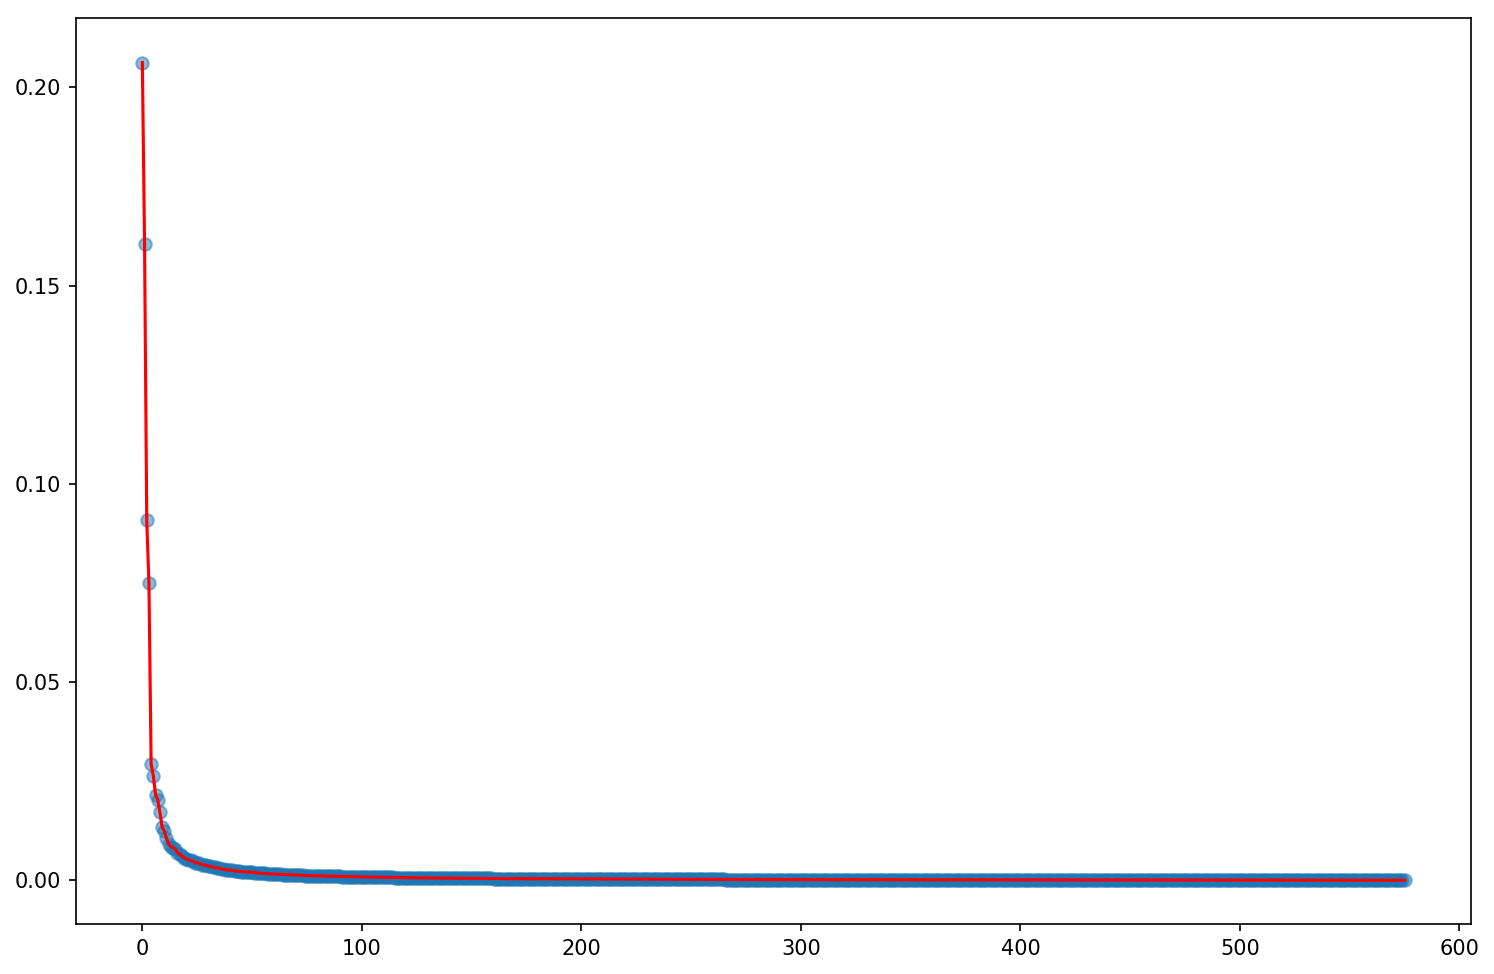

In [21]:
pca.fit(df.drop(["label"], axis = 1))

plt.plot(range(len(pca.explained_variance_ratio_)), list(pca.explained_variance_ratio_), color = 'red')
plt.scatter(range(len(pca.explained_variance_ratio_)), list(pca.explained_variance_ratio_) ,alpha=0.5)
plt.show()

In [27]:
sign_shape = {11: "uptriangle",
         13: "downtriangle",
         14: "octagon",
         18: "uptriangle",
         20: "uptriangle"}

df["shape"] = df["label"].apply(lambda lab: sign_shape.get(lab, "circle"))

In [28]:
df["shape"].unique()

array(['circle', 'uptriangle', 'downtriangle', 'octagon'], dtype=object)

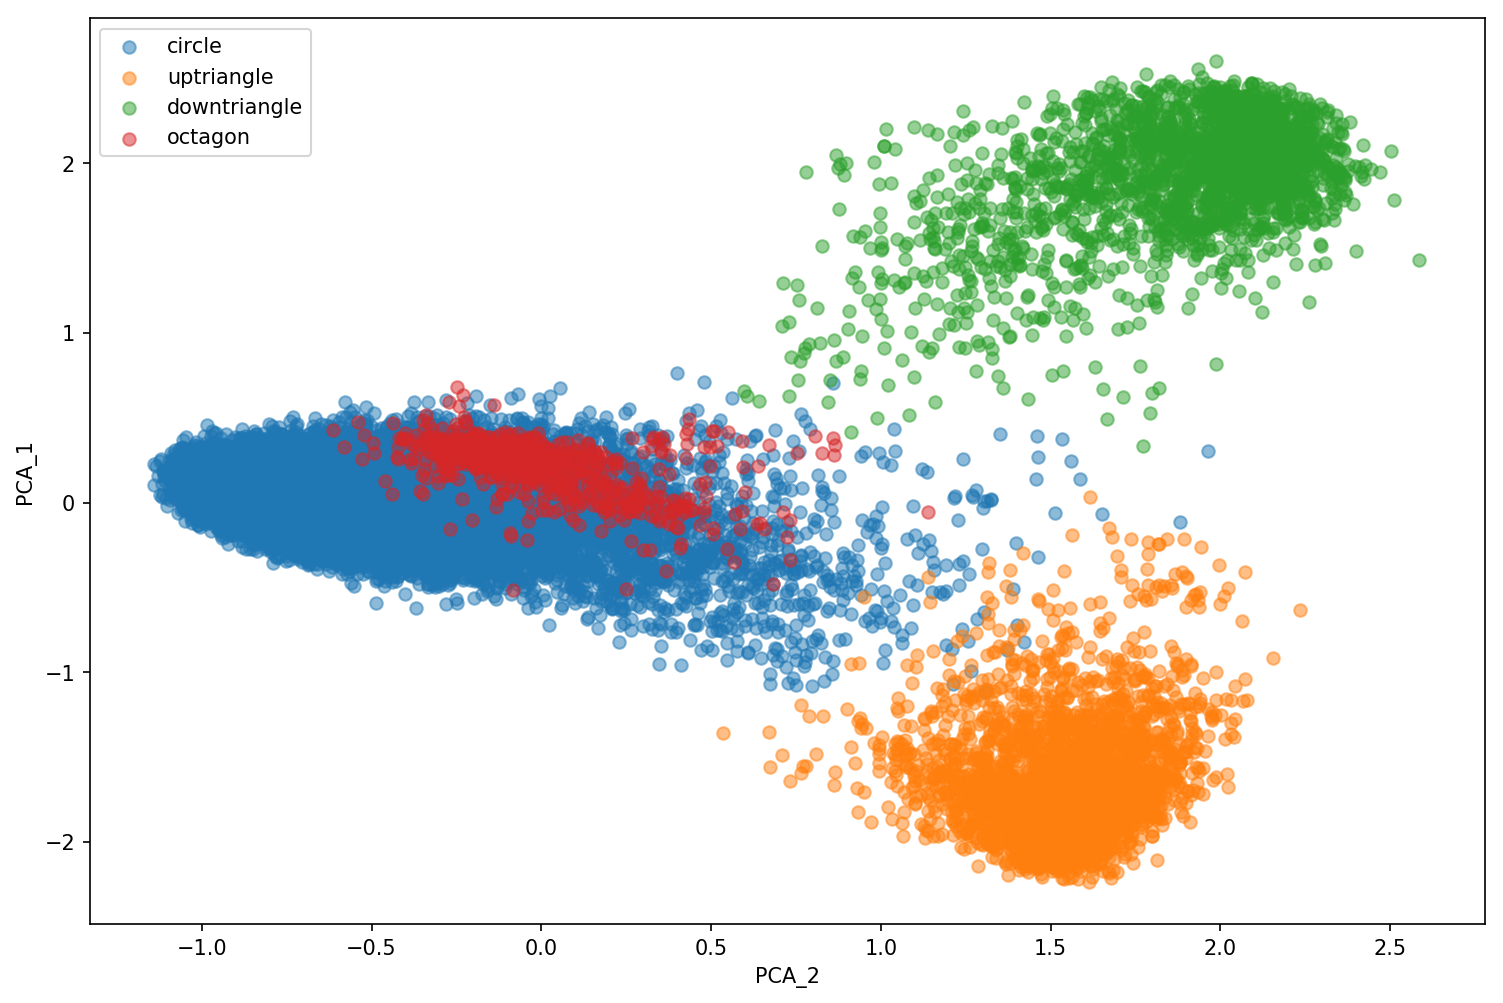

In [62]:
# pca_data = pca.transform(df.drop(["label", "shape"], axis = 1))[:, :2]
df["pca_1"] = pca_data[:,0]
df["pca_2"] = pca_data[:,1]
for lab in df["shape"].unique():
    data_ = df.loc[df["shape"] == lab, ["pca_1", "pca_2"]]
    plt.scatter(data_.iloc[:,0], data_.iloc[:,1], alpha=0.5)
plt.legend(df["shape"].unique())
plt.xlabel("PCA_2")
plt.ylabel("PCA_1")
plt.show()

# Fitting LDA

In [64]:
lda.fit(df.drop(["label", "shape", "pca_1", "pca_2"], axis = 1), df["label"])

lda_predictions = lda.predict(df.drop(["label", "shape", "pca_1", "pca_2"], axis = 1))
metrics.accuracy_score(df["label"] , lda_predictions)

0.9591049028167072

In [65]:
wrong_pred = df.loc[df["label"] != lda_predictions]

In [66]:
print(Counter(wrong_pred["label"]))
print(Counter(df["label"]), end = "\n\n")
print(Counter(wrong_pred["label"]).most_common())

Counter({1: 167, 2: 149, 5: 120, 8: 94, 3: 84, 7: 84, 4: 81, 0: 21, 9: 21, 18: 16, 20: 16, 14: 13, 15: 12, 16: 4, 13: 3, 17: 3, 11: 2})
Counter({1: 2184, 2: 2171, 13: 2143, 4: 1958, 5: 1791, 9: 1436, 7: 1394, 3: 1381, 8: 1378, 11: 1309, 18: 1189, 17: 1074, 14: 771, 15: 619, 16: 408, 20: 349, 0: 208})

[(1, 167), (2, 149), (5, 120), (8, 94), (3, 84), (7, 84), (4, 81), (0, 21), (9, 21), (18, 16), (20, 16), (14, 13), (15, 12), (16, 4), (13, 3), (17, 3), (11, 2)]


# Fitting SVC linear

In [70]:
svc.fit(df.drop(["label", "shape", "pca_1", "pca_2"], axis = 1), df["label"])

# svc_predictions = svc.predict(df.drop(["label", "shape", "pca_1", "pca_2"], axis = 1))
# metrics.accuracy_score(df["label"] , svc_predictions)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [68]:
fdf[df["label"] != svc_predictions].shape

(218, 580)